<b> <font size="+2.5"> Create gene expression plotting object
 </b> </font> <br>

Date: 2023-12-27 <br>
Author: ASF

# Load libraries

In [1]:
### Set up
suppressPackageStartupMessages({
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
library(readxl)
library(edgeR)
library(ggpubr)
library(cowplot)
})

# Read in meta data

In [2]:
meta_data <- as.data.frame(read.delim("../datasets/adata.obs_20231120.tsv", sep='\t'))

In [3]:
#select columns of interest
meta_data_subset <- meta_data[c("sample","individual","Age", "Sex", "Status", "RIN", "Brain.pH", "PMI", 
                                "X6.Batch")]

#keep only unique observations (one line per individual)
meta_data_subset <- meta_data_subset %>% distinct(individual, .keep_all=TRUE)

meta_data_subset$Status <- as.character(meta_data_subset$Status)
meta_data_subset$Disease_Status <- ifelse(meta_data_subset$Status=='0', 'Controls', 'Cases')
meta_data_subset$Disease_Status <- factor(meta_data_subset$Disease_Status, levels=c('Controls', 'Cases'))

dim(meta_data_subset)
#head(meta_data_subset)

[1] 87 10

In [4]:
# Set missing RIN to median
meta_data_subset$RIN[is.na(meta_data_subset$RIN)] <- median(meta_data_subset$RIN, na.rm=TRUE) 

#change column names
colnames(meta_data_subset)[which(names(meta_data_subset) == 'Brain.pH')] <- 'pH'
colnames(meta_data_subset)[which(names(meta_data_subset) == 'X6.Batch')] <- 'lib_batch'
meta_data_subset$lib_batch <- as.character(meta_data_subset$lib_batch)

# order by individual identifier (descending)
meta_data_subset <- meta_data_subset[order(meta_data_subset$individual),]
#head(meta_data_subset)

In [5]:
# read in PC1_hidden_noise
PC1 <- read_xlsx(path = "../datasets/PC1_hidden_confounders.xlsx")
#this table needs to be in the same order (individual)
# check: 
unique(meta_data_subset$individual == PC1$individual)

meta_data_subset <- merge(meta_data_subset, PC1, by='individual')
colnames(meta_data_subset)[which(names(meta_data_subset) == 'PC1_hidden_noise')] <- 'PC1'

[1] TRUE

# Read in pseudocount matrices from all cell types

see folder 04; script 01a_make_pseudobulk_cell_types_final.ipynb to obtain pseudobulk counts

In [6]:
# make a list of all the file names you want to read in 
files <- list.files(path="../datasets/PseudoBulkFinal", pattern="^.[^L].*matrix.tsv$", full.names=T)

#read in all count matrices of all cell types and put in a list object
#make temporary object (tmp) to assign the rownames with individual and remove 
#first and second column that is not count data and transpose using t
counts_list=lapply(files, function(x) { 
  tmp=base::as.data.frame(read.delim(x, sep='\t', head=T))
  rownames(tmp)=tmp[,2] 
  return( base::as.data.frame(t( tmp[,-c(1:2)])) )
} 
)

#assign the names of the cell types to the corresponding list in the object counts list
names(counts_list)=gsub(files, pattern="^.*PseudoBulkFinal.|_pseudobulk.*$", replacement="")

summary(counts_list)

                Length Class      Mode
Astro_FB        87     data.frame list
Astro_PP        87     data.frame list
Endothelial     87     data.frame list
Exc_L2-3        87     data.frame list
Exc_L3-5        87     data.frame list
Exc_L4-6_1      87     data.frame list
Exc_L4-6_2      87     data.frame list
Exc_L4-6_3      85     data.frame list
Exc_L5-6_1      86     data.frame list
Exc_L5-6_2      82     data.frame list
Exc_L5-6_HTR2C  85     data.frame list
In_LAMP5_1      87     data.frame list
In_LAMP5_2      87     data.frame list
In_PVALB_Ba     87     data.frame list
In_PVALB_Ch     87     data.frame list
In_RELN         87     data.frame list
In_SST          87     data.frame list
In_VIP          87     data.frame list
Microglia       87     data.frame list
Oligodendrocyte 87     data.frame list
OPC             87     data.frame list

## filter genes

<b>  <font size="+2.5">  60 % </b>

In [7]:
########## FILTER genes 
#counts >10 and expressed in >60% individuals

celltypes <- names(counts_list)

counts_10_60 <- list()
for (i in celltypes){
  tmp <- counts_list[[i]]
  tmp2 <- tmp[rowSums(tmp > 10) > (0.6*dim(tmp)[2]),] # filter based on 60% of specific cell type
  counts_10_60[[i]] <- tmp2 
}

#save  filtered counts
save(counts_10_60, file = "../datasets/counts_10_60.RData")

In [8]:
# count how many genes are left after applying counts filter
n_genes_tested <- as.data.frame(matrix(ncol=3, nrow = 0))
for (i in celltypes){
  tmp <- counts_10_60[[i]]
  n_genes <- as.data.frame(t(c(i, dim(tmp)[1], dim(tmp)[2])))
  n_genes_tested <- rbind(n_genes_tested, n_genes)
}
colnames(n_genes_tested) <- c('celltype', 'n_genes','n_individuals')
n_genes_tested$n_genes <- as.numeric(n_genes_tested$n_genes)
n_genes_tested$n_individuals <- as.numeric(n_genes_tested$n_individuals)
n_genes_tested <- n_genes_tested[order(-n_genes_tested$n_genes),] # order descending
head(n_genes_tested)

,celltype,n_genes,n_individuals
,<chr>,<dbl>,<dbl>
4,Exc_L2-3,18898,87
6,Exc_L4-6_1,13574,87
18,In_VIP,12865,87
7,Exc_L4-6_2,12825,87
14,In_PVALB_Ba,12549,87
17,In_SST,11081,87


In [ ]:
# min.count=10, min.prop=0.8, min.cells=5, min.samples=61
# minimum number of observed cells for a sample to be included in the analysis: this should barely change anything
# minimum numberof reads for a gene to be considered expressed in a sample. PassedtoedgeR::filterByExpr 
# min.samples minimum number of samples passing cutoffs for cell cluster to be retained

# Normalization

In [9]:
########## CREATE DGEList OBJECT and calculate NORMFACTORS
DGE_list <- list()
for (celltype in names(counts_10_60)){
  tmp <- counts_10_60[[celltype]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <- meta_data_subset[!meta_data_subset$individual %in%  missing,]
  DGE_object <- DGEList(tmp, samples = meta_data_updated) #make DGE object
  DGE_object <- calcNormFactors(DGE_object) # calculate normfactors
  DGE_list[[celltype]] <- DGE_object } else {
    DGE_object <- DGEList(tmp, samples = meta_data_subset) #make DGE object
    DGE_object <- calcNormFactors(DGE_object) # calculate normfactors
    DGE_list[[celltype]] <- DGE_object }
}

In [10]:
########## VOOM TRANSFORMATION
#define model
des <- "~ Disease_Status + Sex + Age + pH + RIN + PMI + lib_batch + PC1"
# specify model to fitted
mm <- model.matrix(as.formula(des), data = meta_data_subset)

# WHAT DOES VOOM DO?
# If counts is a DGEList object from the edgeR package, then voom will use the normalization factors found in the object when computing the logCPM values. In other words, the logCPM values are computed from the effective library sizes rather than the raw library sizes.
# A linear model is fitted to the log2 CPM for each gene, and the residuals are calculated
#A smoothed curve is fitted to the sqrt(residual standard deviation) by average expression (see red line in plot above)
#The smoothed curve is used to obtain weights for each gene and sample that are passed into limma along with the log2 CPMs.

voom_counts_10_60 <- list()
for (celltype in names(DGE_list)){
  tmp <- DGE_list[[celltype]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <-meta_data_subset[!meta_data_subset$individual %in%  missing,]
    mm_updated <- model.matrix(as.formula(des), data = meta_data_updated)
    voom_counts_10_60[[celltype]] <- voom(tmp, mm_updated, plot = F)} 
  else{
    voom_counts_10_60[[celltype]] <- voom(tmp, mm, plot = F)}
}


# Remove batch effects

In [11]:
########## REMOVE BATCH EFFECTS

# Define own method that is able to remove 3 categorical batch variables
# written by Nathalie Gerstner
remove3BatchEffects <- function(x,batch=NULL,batch2=NULL,batch3=NULL,
                                covariates=NULL,design=matrix(1,ncol(x),1),...)
  #  Remove batch effects from matrix of expression data
  #  Adapted from Gordon Smyth and Carolyn de Graaf
  #  Created 1 Aug 2008. Last revised 1 June 2014.
{
  if(is.null(batch) && is.null(batch2) && is.null(batch3) && is.null(covariates)) return(as.matrix(x))
  if(!is.null(batch)) {
    batch <- as.factor(batch)
    contrasts(batch) <- contr.sum(levels(batch))
    batch <- model.matrix(~batch)[,-1,drop=FALSE]
  }
  if(!is.null(batch2)) {
    batch2 <- as.factor(batch2)
    contrasts(batch2) <- contr.sum(levels(batch2))
    batch2 <- model.matrix(~batch2)[,-1,drop=FALSE]
  }
  if(!is.null(batch3)) {
    batch3 <- as.factor(batch3)
    contrasts(batch3) <- contr.sum(levels(batch3))
    batch3 <- model.matrix(~batch3)[,-1,drop=FALSE]
  }
  if(!is.null(covariates)) covariates <- as.matrix(covariates)
  X.batch <- cbind(batch,batch2,batch3,covariates)
  fit <- lmFit(x,cbind(design,X.batch),...)
  beta <- fit$coefficients[,-(1:ncol(design)),drop=FALSE]
  beta[is.na(beta)] <- 0
  as.matrix(x) - beta %*% t(X.batch)
}

In [12]:
#use the remove3BatchEffects() adapted by Nathalie 
# removeBatchEffects() expects numeric matrix with log-expression values
# matrix with rows corresponding to genes and columns corresponding to samples
counts_batches_removed <- list()
for (i in celltypes){
  tmp <- voom_counts_10_60[[i]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <-meta_data_subset[!meta_data_subset$individual %in%  missing,]
    tmp2 <- remove3BatchEffects(tmp, batch = meta_data_updated$Disease_Status, batch2 = meta_data_updated$Sex, 
                                batch3 = meta_data_updated$lib_batch,
                                covariates = meta_data_updated[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed[[i]] <- tmp2
  } else {
    tmp2 <- remove3BatchEffects(tmp, batch = meta_data_subset$Disease_Status, batch2 = meta_data_subset$Sex,
                                batch3 = meta_data_subset$lib_batch,
                                covariates = meta_data_subset[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed[[i]] <- tmp2
  }}

save(counts_batches_removed, file = "../plotting_objects/plotting_object_batch_corrected.RData")

In [13]:
##### remove all batches except Age and Status 
#(for genes influenced by both age and disease status)
#use standard removeBatchEffect() from limma
counts_batches_removed_Age_Status <- list()
for (i in celltypes){
  tmp <- voom_counts_10_60[[i]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <-meta_data_subset[!meta_data_subset$individual %in%  missing,]
    tmp2 <- removeBatchEffect(tmp, batch = meta_data_updated$lib_batch, batch2 = meta_data_updated$Sex,
                                covariates = meta_data_updated[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed_Age_Status[[i]] <- tmp2
  } else {
    tmp2 <- removeBatchEffect(tmp, batch = meta_data_subset$lib_batch, batch2 = meta_data_subset$Sex,
                                covariates = meta_data_subset[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed_Age_Status[[i]] <- tmp2
  }}

save(counts_batches_removed_Age_Status, file = "../plotting_objects/plotting_object_corrected_NOT_age_status.RData")

In [14]:
head(counts_batches_removed_Age_Status[['Astro_FB']])

,255,294,306,308,319,323,331,333,338,339,⋯,795,799,804,808,816,817,826,828,847,854
ENSG00000000419,9.79534640,9.319301,9.526264,9.4615076,9.420999,10.340683,9.852317,9.891357,9.218935,9.044128,⋯,9.844865,10.0136097,9.8196939,9.8669231,9.4059447,9.503130,9.782084,9.6118284,9.389633,10.056707
ENSG00000001084,7.20375215,7.195058,6.534829,6.6704275,6.316455,7.296748,7.466151,7.682785,7.112901,7.235895,⋯,7.133476,7.3625164,6.2907995,7.6164622,6.8405333,6.774600,7.172324,6.6295439,6.229805,6.519246
ENSG00000001629,7.75224233,8.054313,7.678207,7.9765801,7.949396,8.024104,7.760580,7.484818,7.898452,8.076896,⋯,7.668754,7.7080222,7.7521697,7.7917535,7.9122735,7.720927,8.097976,7.7787074,7.594850,8.472014
ENSG00000001630,0.03440276,-1.312266,-1.403054,-0.1469431,-1.814974,-1.194474,-1.435626,-2.190193,-1.031756,-1.154788,⋯,-1.100046,-0.7375724,-0.8088441,-0.5436202,-0.9301849,-1.035168,-1.111256,-0.5297242,-1.594145,-3.399446
ENSG00000001631,6.60730251,6.459579,6.246465,6.4975265,6.261070,6.804059,6.556625,6.645115,6.589561,6.871561,⋯,6.468556,6.2993665,6.4228079,6.4875469,6.5688463,6.389940,6.383311,6.2000763,6.523600,6.819902
ENSG00000002016,7.14135797,7.413287,7.400950,6.8139003,7.163242,6.918925,6.902622,7.431738,7.555678,6.714471,⋯,6.963965,6.8943910,7.2448377,6.7184574,6.9184867,7.183155,6.973288,6.9153625,7.073571,5.727614


# Plot genes of interest

## Fig. 3a-f - age-associated genes

In [ ]:
load('../plotting_objects/plotting_object_batch_corrected.RData')

In [15]:
# read in the gene information to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')
head(gene_names_ensembl)

,ID,ensembl
,<chr>,<chr>
1,AL627309.1,ENSG00000238009
2,AL627309.5,ENSG00000241860
3,LINC01409,ENSG00000237491
4,LINC01128,ENSG00000228794
5,LINC00115,ENSG00000225880
6,FAM41C,ENSG00000230368


In [16]:
# Age effect
# genes at FDR < 0.05
DE_genes_Age <- list()
for (celltype in celltypes){
    tmp <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
    tmp <- tmp[tmp$adj.P.Val < 0.05,]
    #merge gene ID and ensembl ID
    DE_genes_Age[[celltype]] <- merge(tmp, gene_names_ensembl, by='ID')
}

In [17]:
######### EXTRACT counts of DE genes from plotting object
DE_Age_counts <- list()
for (celltype in names(DE_genes_Age)){
  counts <- data.frame(t(counts_batches_removed[[celltype]])) # transpose, now: col= genes, rows=individuals
  DE_genes <- DE_genes_Age[[celltype]]$ensembl
  DE_genes_counts <- dplyr::select(counts, all_of(DE_genes))
  DE_genes_counts$individual <- as.character(rownames(DE_genes_counts))
  DE_Age_counts[[celltype]] <- DE_genes_counts
}


# add meta_data to DE gene counts
DE_Age_counts_w_meta_data <- list()
for (celltype in names(DE_genes_Age)){
  tmp <- DE_Age_counts[[celltype]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <- meta_data_subset[!meta_data_subset$individual %in%  missing,]
    tmp2 <- merge(tmp, meta_data_updated, by='individual')
    DE_Age_counts_w_meta_data[[celltype]] <- tmp2 }
  tmp2 <- merge(tmp, meta_data_subset, by='individual')
  DE_Age_counts_w_meta_data[[celltype]] <- tmp2
}

In [18]:
##### IMPORTANT -> cell types have to be in alphabetical order - otherwise the automatic colouring will not work in the plotting function below
celltype_colours <- c('#BCAC9B', '#DDC9B4','#6e4c3c', '#2B3A67', '#588157', '#A3B18A', '#2A3D45', '#496A81',
            '#66999B',  '#748b97', '#727D71', '#C17C74', '#dab2ad', '#E26D5C','#EA8C55', '#781F19',
            '#723D46','#472D30','#7A6C5D', '#FFE1A8','#FFC482')

names(celltype_colours) <- c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", 
                             "Exc_L4-6_2","Exc_L4-6_3", "Exc_L5-6_1", "Exc_L5-6_2", "Exc_L5-6_HTR2C", 
                             "In_LAMP5_1", "In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", "In_RELN", "In_SST",
                             "In_VIP","Microglia", "Oligodendrocyte", "OPC")

[1] "ENSG00000152495"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


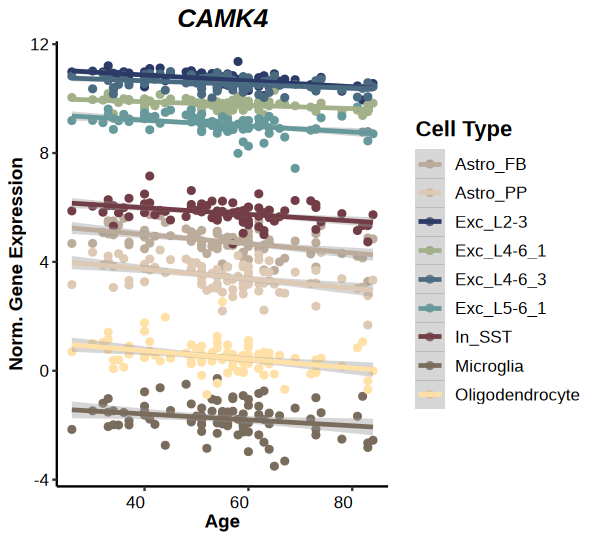

In [19]:
### Plot genes of interest in multiple cell types

# CAMK4 
CAMK4_ensembl <- DE_genes_Age[['In_SST']]$ensembl[which(DE_genes_Age[['In_SST']]$ID=='CAMK4')]

CAMK4 <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(CAMK4) <- c('individual', 'Age', 'Status', CAMK4_ensembl, 'celltype')
for (celltype in names(DE_genes_Age)) {
  tmp <- DE_Age_counts_w_meta_data[[celltype]]
  if (CAMK4_ensembl %in% colnames(tmp)){
    temp <- tmp %>% dplyr::select(all_of(c('individual', 'Age', 'Status', CAMK4_ensembl)))
    temp$celltype <- celltype
    CAMK4 <- rbind(CAMK4, temp)}
  else {next}
}

colours_f_plot <- celltype_colours[names(celltype_colours) %in% c(unique(CAMK4$celltype))]

#print ensembl_id and manually insert
CAMK4_ensembl 

options(repr.plot.width=5, repr.plot.height=4.5)
CAMK4 %>%
  ggplot(aes(x= Age,ENSG00000152495)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('CAMK4')+ scale_color_manual(name = "Cell Type",values=colours_f_plot) 

ggsave('../figures/CAMK4_expr_mult_celltypes.pdf', plot=last_plot(), width=4.5, height=4)

[1] "ENSG00000096060"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


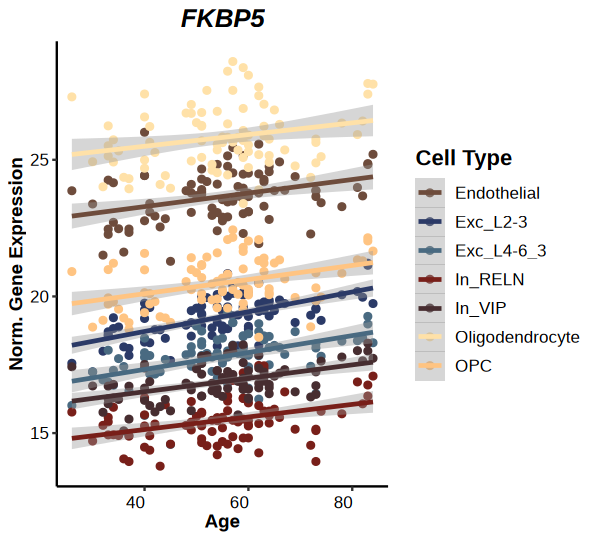

In [20]:
# FKBP5 
FKBP5_ensembl <- DE_genes_Age[['Exc_L2-3']]$ensembl[which(DE_genes_Age[['Exc_L2-3']]$ID=='FKBP5')]

FKBP5 <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(FKBP5) <- c('individual', 'Age', 'Status', FKBP5_ensembl, 'celltype')
for (celltype in names(DE_genes_Age)) {
  tmp <- DE_Age_counts_w_meta_data[[celltype]]
  if (FKBP5_ensembl %in% colnames(tmp)){
    temp <- tmp %>% dplyr::select(all_of(c('individual', 'Age', 'Status', FKBP5_ensembl)))
    temp$celltype <- celltype
    FKBP5 <- rbind(FKBP5, temp)}
  else {next}
}

colours_f_plot <- celltype_colours[names(celltype_colours) %in% c(unique(FKBP5$celltype))]

#print ensembl_id and manually insert
FKBP5_ensembl

FKBP5 %>%
  ggplot(aes(x= Age,ENSG00000096060)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('FKBP5')+ scale_color_manual(name = "Cell Type",values=colours_f_plot) 

ggsave('../figures/FKBP5_expr_mult_celltypes.pdf', plot=last_plot(), width=4.5, height=4)

[1] "ENSG00000134986"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


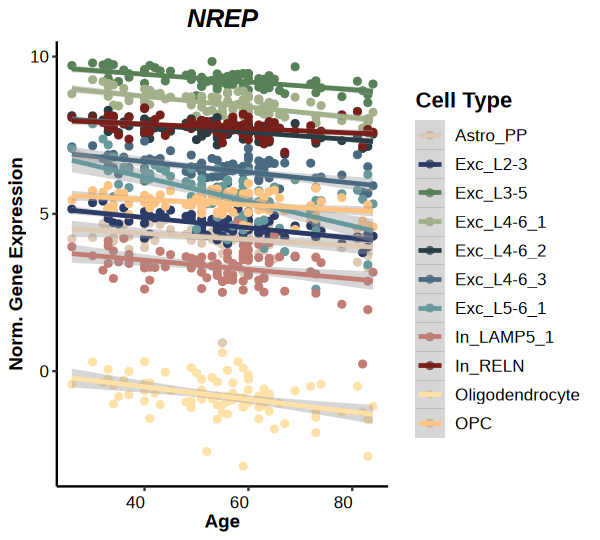

In [21]:
# NREP 
NREP_ensembl <- DE_genes_Age[['Exc_L2-3']]$ensembl[which(DE_genes_Age[['Exc_L2-3']]$ID=='NREP')]

NREP <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(NREP) <- c('individual', 'Age', 'Status', NREP_ensembl, 'celltype')
for (celltype in names(DE_genes_Age)) {
  tmp <- DE_Age_counts_w_meta_data[[celltype]]
  if (NREP_ensembl %in% colnames(tmp)){
    temp <- tmp %>% dplyr::select(all_of(c('individual', 'Age', 'Status', NREP_ensembl)))
    temp$celltype <- celltype
    NREP <- rbind(NREP, temp)}
  else {next}
}

colours_f_plot <- celltype_colours[names(celltype_colours) %in% c(unique(NREP$celltype))]

#print ensembl_id and manually insert
NREP_ensembl

NREP %>%
  ggplot(aes(x= Age,ENSG00000134986)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('NREP')+ scale_color_manual(name = "Cell Type",values=colours_f_plot) 

ggsave('../figures/NREP_expr_mult_celltypes.pdf', plot=last_plot(), width=4.5, height=4)

[1] "ENSG00000106236"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


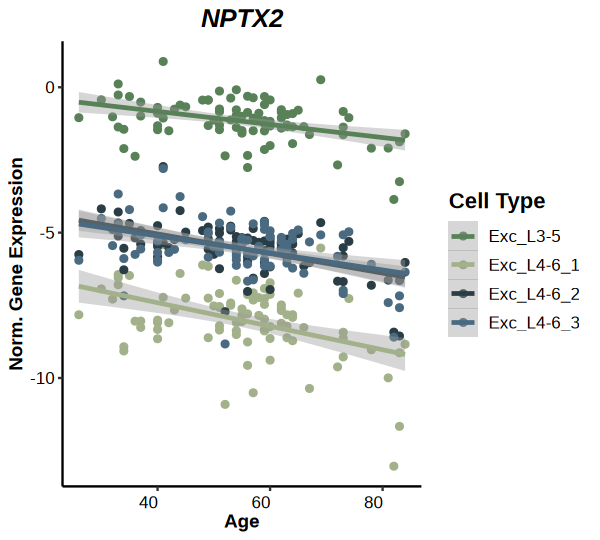

In [22]:
# NPTX2 
NPTX2_ensembl <- DE_genes_Age[['Exc_L3-5']]$ensembl[which(DE_genes_Age[['Exc_L3-5']]$ID=='NPTX2')]

NPTX2 <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(NPTX2) <- c('individual', 'Age', 'Status', NPTX2_ensembl, 'celltype')
for (celltype in names(DE_genes_Age)) {
  tmp <- DE_Age_counts_w_meta_data[[celltype]]
  if (NPTX2_ensembl %in% colnames(tmp)){
    temp <- tmp %>% dplyr::select(all_of(c('individual', 'Age', 'Status', NPTX2_ensembl)))
    temp$celltype <- celltype
    NPTX2 <- rbind(NPTX2, temp)}
  else {next}
}

colours_f_plot <- celltype_colours[names(celltype_colours) %in% c(unique(NPTX2$celltype))]

#print ensembl_id and manually insert
NPTX2_ensembl

NPTX2 %>%
  ggplot(aes(x= Age,ENSG00000106236)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('NPTX2')+ scale_color_manual(name = "Cell Type",values=colours_f_plot) 

ggsave('../figures/NPTX2_expr_mult_celltypes.pdf', plot=last_plot(), width=4.5, height=4)

[1] "ENSG00000110077"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


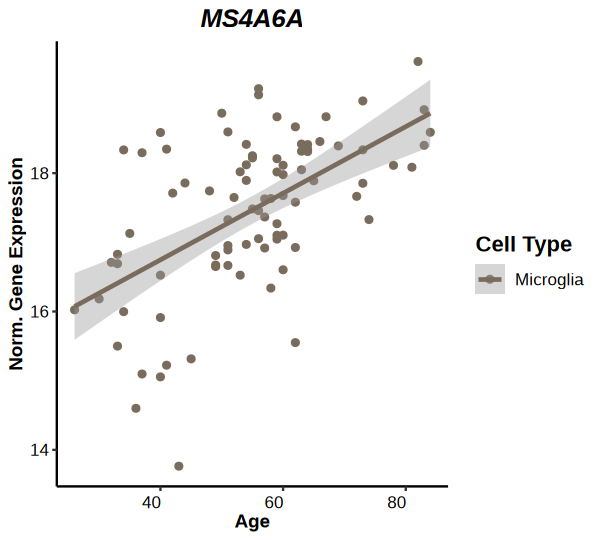

In [23]:
# MS4A6A 
MS4A6A_ensembl <- DE_genes_Age[['Microglia']]$ensembl[which(DE_genes_Age[['Microglia']]$ID=='MS4A6A')]

MS4A6A <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(MS4A6A) <- c('individual', 'Age', 'Status', MS4A6A_ensembl, 'celltype')
for (celltype in names(DE_genes_Age)) {
  tmp <- DE_Age_counts_w_meta_data[[celltype]]
  if (MS4A6A_ensembl %in% colnames(tmp)){
    temp <- tmp %>% dplyr::select(all_of(c('individual', 'Age', 'Status', MS4A6A_ensembl)))
    temp$celltype <- celltype
    MS4A6A <- rbind(MS4A6A, temp)}
  else {next}
}

colours_f_plot <- celltype_colours[names(celltype_colours) %in% c(unique(MS4A6A$celltype))]

#print ensembl_id and manually insert
MS4A6A_ensembl

MS4A6A %>%
  ggplot(aes(x= Age,ENSG00000110077)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('MS4A6A')+ scale_color_manual(name = "Cell Type",values=colours_f_plot) 

ggsave('../figures/MS4A6A_expr_microglia.pdf', plot=last_plot(), width=4.5, height=4)

[1] "ENSG00000196126"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


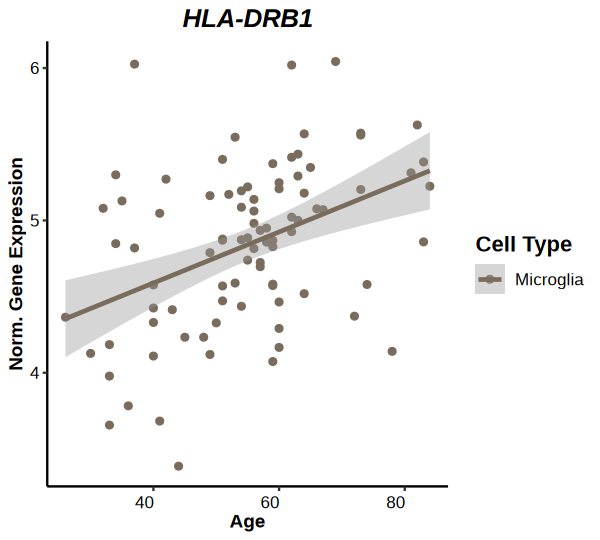

In [24]:
# HLA-DRB1 
HLA_DRB1_ensembl <- DE_genes_Age[['Microglia']]$ensembl[which(DE_genes_Age[['Microglia']]$ID=='HLA-DRB1')]

HLA_DRB1 <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(HLA_DRB1) <- c('individual', 'Age', 'Status', HLA_DRB1_ensembl, 'celltype')
for (celltype in names(DE_genes_Age)) {
  tmp <- DE_Age_counts_w_meta_data[[celltype]]
  if (HLA_DRB1_ensembl %in% colnames(tmp)){
    temp <- tmp %>% dplyr::select(all_of(c('individual', 'Age', 'Status', HLA_DRB1_ensembl)))
    temp$celltype <- celltype
    HLA_DRB1 <- rbind(HLA_DRB1, temp)}
  else {next}
}

colours_f_plot <- celltype_colours[names(celltype_colours) %in% c(unique(HLA_DRB1$celltype))]

#print ensembl_id and manually insert
HLA_DRB1_ensembl 

HLA_DRB1 %>%
  ggplot(aes(x= Age,ENSG00000196126)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('HLA-DRB1')+ scale_color_manual(name = "Cell Type",values=colours_f_plot) 

ggsave('../figures/HLA-DRB1_expr_microglia.pdf', plot=last_plot(), width=4.5, height=4)

## logFC of genes of interest across cell types

In [25]:
FKBP5_logFC_range <- c()
for (celltype in names(DE_genes_Age)){
    if ('FKBP5' %in% DE_genes_Age[[celltype]]$ID){
        tmp <- DE_genes_Age[[celltype]][DE_genes_Age[[celltype]]$ID=='FKBP5','logFC']
        names(tmp) <- celltype
        FKBP5_logFC_range <- c(FKBP5_logFC_range, tmp)
    }
}
FKBP5_logFC_range <- sort(FKBP5_logFC_range, decreasing = T)
length(FKBP5_logFC_range)
FKBP5_logFC_range

[1] 7

Exc_L2-3 Oligodendrocyte      Exc_L4-6_3             OPC     Endothelial 
     0.04481574      0.03785530      0.03635889      0.03416451      0.03077376 
         In_VIP         In_RELN 
     0.02763804      0.02660094

In [26]:
NREP_logFC_range <- c()
for (celltype in names(DE_genes_Age)){
    if ('NREP' %in% DE_genes_Age[[celltype]]$ID){
        tmp <- DE_genes_Age[[celltype]][DE_genes_Age[[celltype]]$ID=='NREP','logFC']
        names(tmp) <- celltype
        NREP_logFC_range <- c(NREP_logFC_range, tmp)
    }
}
NREP_logFC_range <- sort(NREP_logFC_range, decreasing = F)
length(NREP_logFC_range)
NREP_logFC_range

[1] 11

Exc_L5-6_1      Exc_L4-6_1 Oligodendrocyte        Exc_L2-3      In_LAMP5_1 
    -0.04916874     -0.02208629     -0.02161484     -0.02153525     -0.01949436 
     Exc_L4-6_3        Exc_L3-5        Astro_PP      Exc_L4-6_2             OPC 
    -0.01710540     -0.01686124     -0.01611694     -0.01525160     -0.01146967 
        In_RELN 
    -0.01055235

In [27]:
NPTX2_logFC_range <- c()
for (celltype in names(DE_genes_Age)){
    if ('NPTX2' %in% DE_genes_Age[[celltype]]$ID){
        tmp <- DE_genes_Age[[celltype]][DE_genes_Age[[celltype]]$ID=='NPTX2','logFC']
        names(tmp) <- celltype
        NPTX2_logFC_range <- c(NPTX2_logFC_range, tmp)
    }
}
NPTX2_logFC_range <- sort(NPTX2_logFC_range, decreasing = F)
length(NPTX2_logFC_range)
NPTX2_logFC_range

[1] 4

Exc_L4-6_1  Exc_L4-6_2  Exc_L4-6_3    Exc_L3-5 
-0.03619180 -0.03337407 -0.02674020 -0.02409064

## Fig. 7c-e - genes associated with both age and disease

In [ ]:
load("../plotting_objects/plotting_object_corrected_NOT_age_status.RData")

In [28]:
# Age effect
# genes at FDR < 0.1
DE_genes_Age_FDR0.1 <- list()
for (celltype in celltypes){
    tmp <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
    tmp <- tmp[tmp$adj.P.Val < 0.1,]
    #merge gene ID and ensembl ID
    DE_genes_Age_FDR0.1[[celltype]] <- merge(tmp, gene_names_ensembl, by='ID')
}

# combine all counts with meta data
counts_w_meta_data <- list()
for (celltype in names(DE_genes_Age_FDR0.1)){
  tmp <- data.frame(t(counts_batches_removed_Age_Status[[celltype]]))
  tmp$individual <- rownames(tmp)
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <- meta_data_subset[!meta_data_subset$individual %in%  missing,]
    tmp2 <- merge(tmp, meta_data_updated, by='individual')
    counts_w_meta_data[[celltype]] <- tmp2 }
  tmp2 <- merge(tmp, meta_data_subset, by='individual')
  counts_w_meta_data[[celltype]] <- tmp2
}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


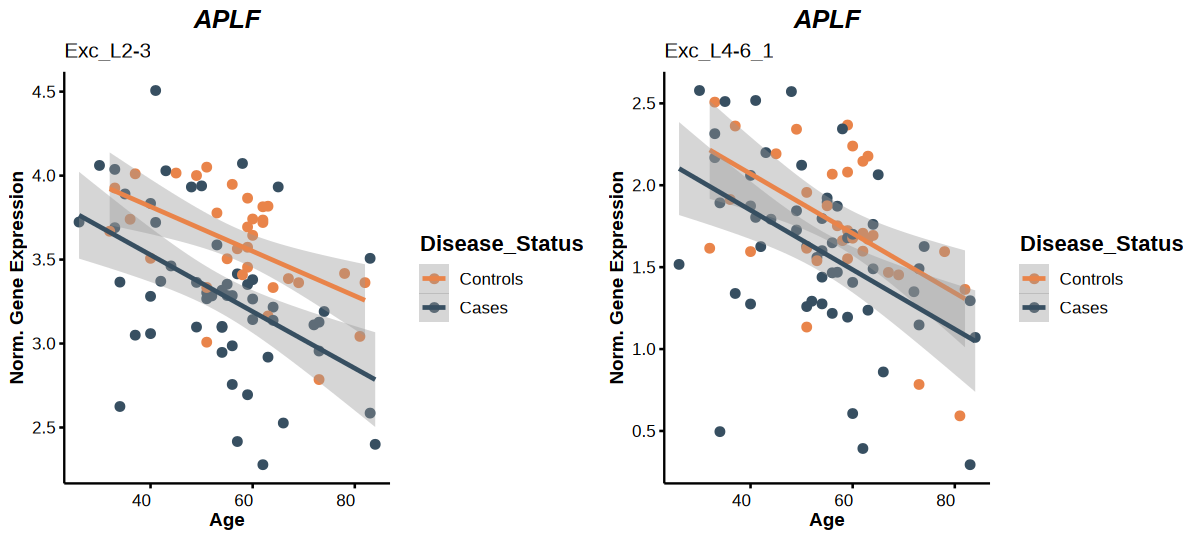

In [29]:
# APLF
APLF_ensembl <- DE_genes_Age_FDR0.1[['Exc_L2-3']]$ensembl[which(DE_genes_Age_FDR0.1[['Exc_L2-3']]$ID=='APLF')]

APLF <- list()
for (celltype in c('Exc_L2-3', 'Exc_L4-6_1')){
    APLF[[celltype]] <- ggscatter(counts_w_meta_data[[celltype]], x = "Age", y = APLF_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle=celltype) + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('APLF') 
}


options(repr.plot.width=10, repr.plot.height=4.5)
plot_grid(plotlist = APLF, nrow=1)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


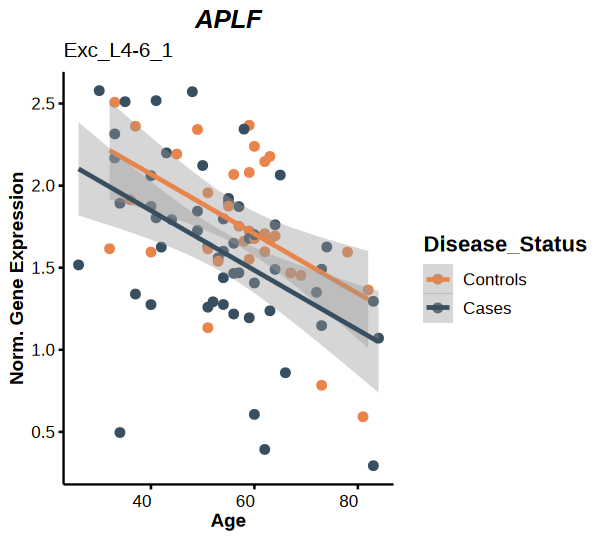

In [39]:
# APLF
APLF_ensembl <- DE_genes_Age_FDR0.1[['Exc_L4-6_1']]$ensembl[which(DE_genes_Age_FDR0.1[['Exc_L4-6_1']]$ID=='APLF')]

# APLF
APLF <- ggscatter(counts_w_meta_data[['Exc_L4-6_1']], x = "Age", y =APLF_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='Exc_L4-6_1') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('APLF')

options(repr.plot.width=5, repr.plot.height=4.5)
APLF
ggsave('../figures/APLF_expr_Exc_L4-6_1_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


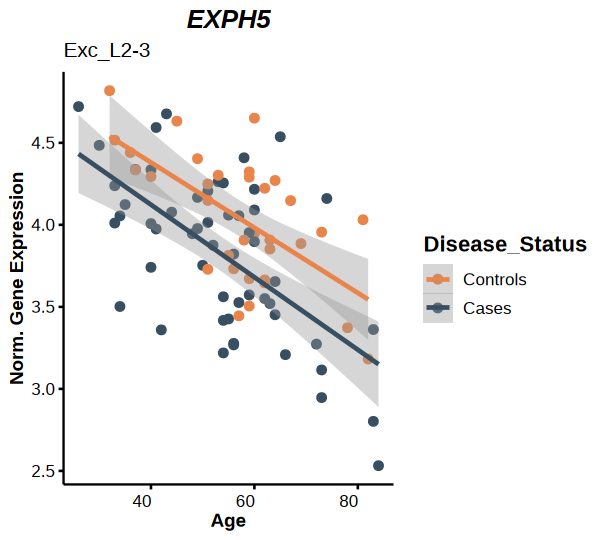

In [31]:
# EXPH5
EXPH5_ensembl <- DE_genes_Age_FDR0.1[['Exc_L2-3']]$ensembl[which(DE_genes_Age_FDR0.1[['Exc_L2-3']]$ID=='EXPH5')]

# EXPH5
EXPH5 <- ggscatter(counts_w_meta_data[['Exc_L2-3']], x = "Age", y = EXPH5_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='Exc_L2-3') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('EXPH5')

options(repr.plot.width=5, repr.plot.height=4.5)
EXPH5
ggsave('../figures/EXPH5_expr_Exc_L2-3_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


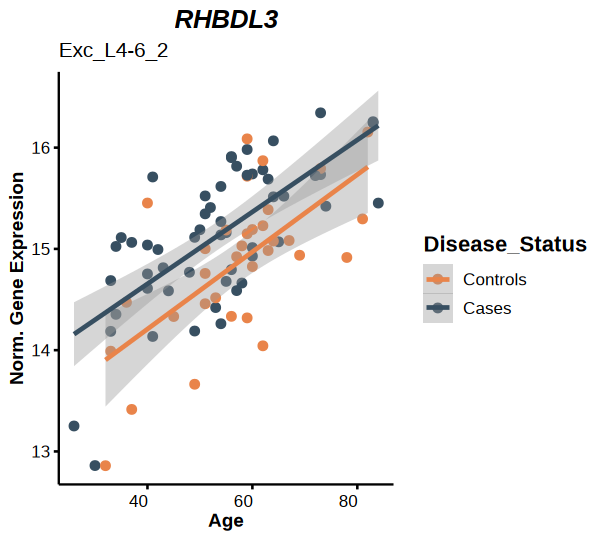

In [32]:
# RHBDL3
RHBDL3_ensembl <- DE_genes_Age_FDR0.1[['Exc_L4-6_2']]$ensembl[which(DE_genes_Age_FDR0.1[['Exc_L4-6_2']]$ID=='RHBDL3')]

# RHBDL3
RHBDL3 <- ggscatter(counts_w_meta_data[['Exc_L4-6_2']], x = "Age", y =RHBDL3_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='Exc_L4-6_2') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('RHBDL3')

options(repr.plot.width=5, repr.plot.height=4.5)
RHBDL3
ggsave('../figures/RHBDL3_expr_Exc_L4-6_2_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


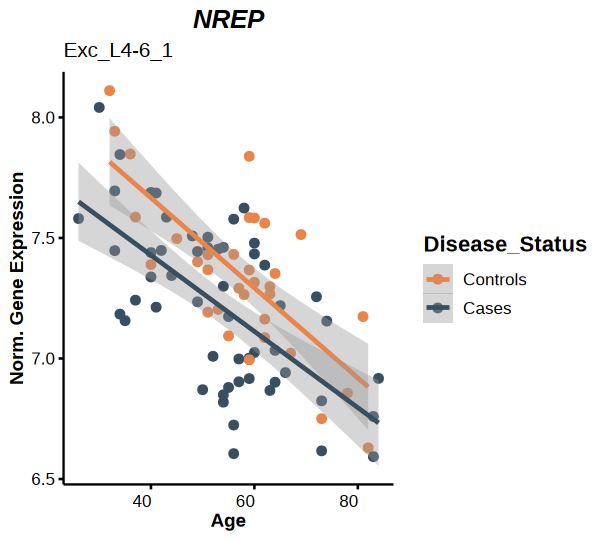

In [33]:
# NREP
NREP_ensembl <- DE_genes_Age_FDR0.1[['Exc_L4-6_1']]$ensembl[which(DE_genes_Age_FDR0.1[['Exc_L4-6_1']]$ID=='NREP')]

# NREP
NREP <- ggscatter(counts_w_meta_data[['Exc_L4-6_1']], x = "Age", y =NREP_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='Exc_L4-6_1') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('NREP')

options(repr.plot.width=5, repr.plot.height=4.5)
NREP
ggsave('../figures/NREP_expr_Exc_L4-6_1_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


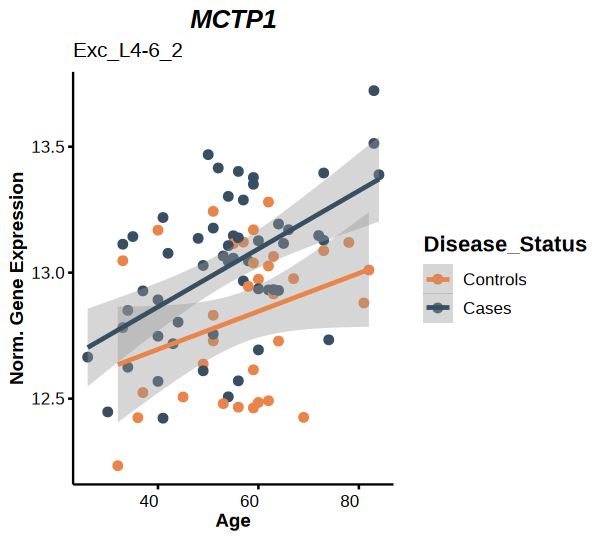

In [34]:
# MCTP1
MCTP1_ensembl <- DE_genes_Age_FDR0.1[['Exc_L4-6_2']]$ensembl[which(DE_genes_Age_FDR0.1[['Exc_L4-6_2']]$ID=='MCTP1')]

# MCTP1
MCTP1 <- ggscatter(counts_w_meta_data[['Exc_L4-6_2']], x = "Age", y =MCTP1_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='Exc_L4-6_2') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('MCTP1')

options(repr.plot.width=5, repr.plot.height=4.5)
MCTP1
ggsave('../figures/MCTP1_expr_Exc_L4-6_2_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

## Extended Data Fig. 9c - genes with interactive effects

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


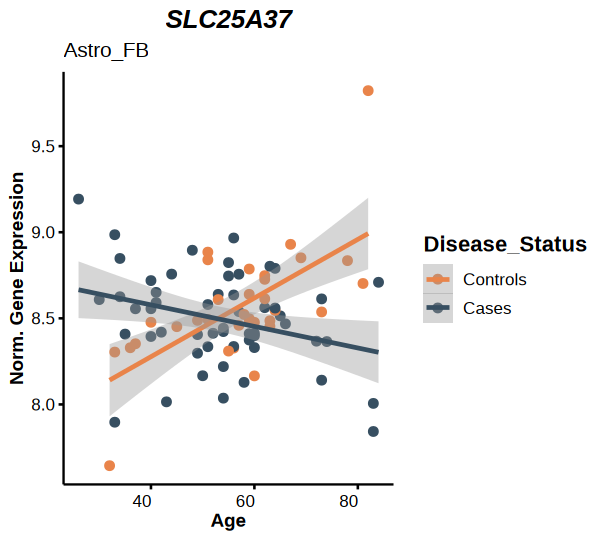

In [35]:
# SLC25A37
SLC25A37_ensembl <- gene_names_ensembl$ensembl[which(gene_names_ensembl$ID=='SLC25A37')]

# SLC25A37
SLC25A37 <- ggscatter(counts_w_meta_data[['Astro_FB']], x = "Age", y =SLC25A37_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='Astro_FB') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('SLC25A37')

options(repr.plot.width=5, repr.plot.height=4.5)
SLC25A37
ggsave('../figures/SLC25A37_expr_Astro_FB_interaction_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


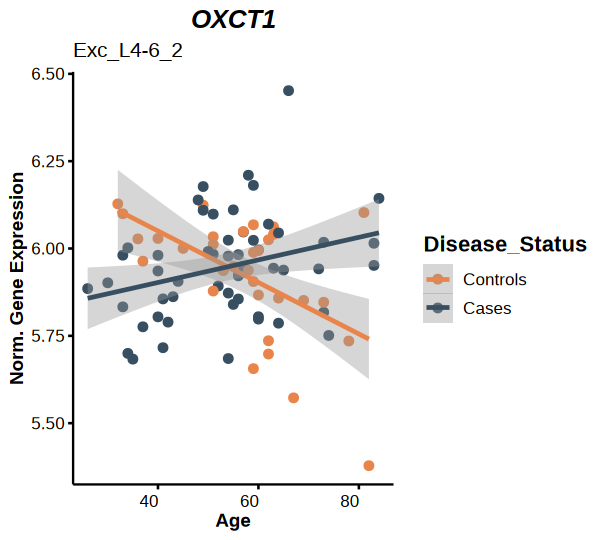

In [36]:
# OXCT1
OXCT1_ensembl <- gene_names_ensembl$ensembl[which(gene_names_ensembl$ID=='OXCT1')]

# OXCT1
OXCT1 <- ggscatter(counts_w_meta_data[['Exc_L4-6_2']], x = "Age", y =OXCT1_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='Exc_L4-6_2') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('OXCT1')

OXCT1
ggsave('../figures/OXCT1_expr_Exc_L4-6_2_interaction_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


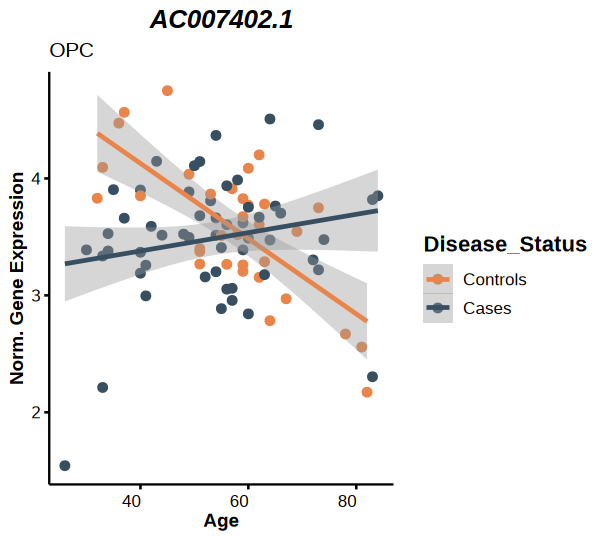

In [37]:
# AC007402.1
AC007402.1_ensembl <- gene_names_ensembl$ensembl[which(gene_names_ensembl$ID=='AC007402.1')]

# AC007402.1
AC007402.1 <- ggscatter(counts_w_meta_data[['OPC']], x = "Age", y =AC007402.1_ensembl, 
          color= 'Disease_Status', palette = c("#e9844a", "#374f61"), xlab = "Age", 
          ylab = "Norm. Gene Expression", subtitle='OPC') + 
geom_smooth(aes(color=`Disease_Status`), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") + ggtitle('AC007402.1')


AC007402.1
ggsave('../figures/AC007402.1_expr_OPC_interaction_Ctrls_vs_Cases.pdf', plot=last_plot(), width=4.5, height=4)

# Session Info

In [38]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1   ggpubr_0.6.0    edgeR_4.0.1     limma_3.58.1   
 [5] readxl_1.4.3    lubridate_1.9.3 forcats_1.0.0   purrr_1.0.2    
 [9] readr_2.1.4     tidyr_1.3.0     tibble_3.2.1    tidyverse_2.0.0
[13]